# src_15

This time I'm using a rectangular mesh. Here, I have three particles.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [212]:
# output directory
src_n = 15
dir = f'../data.lbm/{src_n}/'
# dir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Particles

In [213]:
particlesDf = pd.read_csv(dir+"particlesTrj.csv")
particleIds = np.sort(particlesDf['particleId'].unique())
particleIds

array([1, 2, 3])

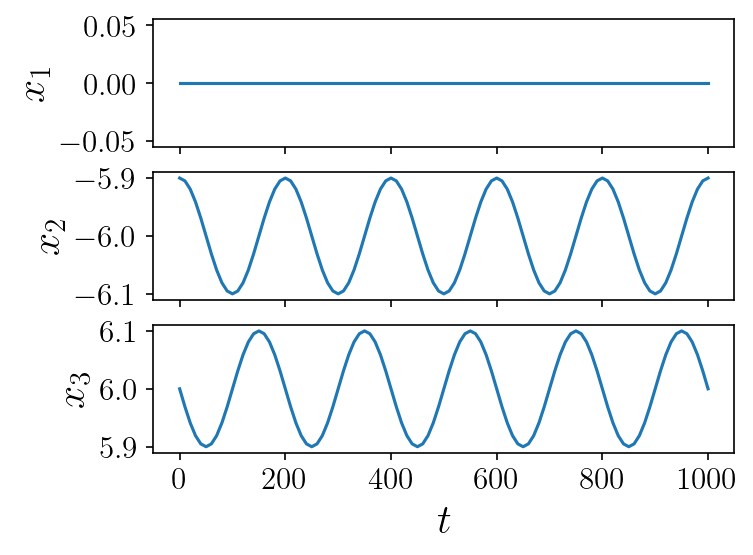

In [214]:
fig, axes = plt.subplots(len(particleIds),1, figsize = (5,1.25*len(particleIds)))

for Id in np.arange(len(particleIds)):
    axes[Id].plot(particlesDf.query(f'particleId == {particleIds[Id]}').time, particlesDf.query(f'particleId == {particleIds[Id]}').position_x)
    axes[Id].set_ylabel(f"$x_{Id+1}$")

for i in range(len(axes)):
    ax = axes.flatten()[i]
    ax.tick_params(labelbottom=False)
    ax.yaxis.set_major_formatter(formatter)

axes[-1].tick_params(labelbottom=True)
axes[-1].set_xlabel("$t$")

plt.show()

# Fluid

In [259]:
def fluidOverview(df):
    # figure preparation
    fig, axes = plt.subplots(2, 1, figsize = (9,3.))

    fig.suptitle(f"$t = {fluidDf.time.values[0]:.0f}$", fontsize=16)
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = fluidDf['coordinate_x'].unique()
    y_unique = fluidDf['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)

    # top plot
    upperLim = 0.003
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes[0].streamplot(X, Y, 
        fluidDf.fluidVelocity_x.unstack().values.transpose(),
        fluidDf.fluidVelocity_y.unstack().values.transpose(),
        density=1.5, linewidth=0.5, color="black",
    )
    axes[0].pcolormesh(X, Y,
        np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.8
    );
    axes[0].tick_params(labelbottom=False)
    axes[0].set_ylabel("$y$")

    cbar_ax = fig.add_axes([0.9, 0.55, 0.02, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.8)
    cbar.set_label(label='$\\mathbf{u}$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.3f}' for tick in custom_ticks])

    # bottom plot
    upperLim = 1.01
    lowerLim = 0.99
    cmap = plt.get_cmap('seismic')
    norm = plt.Normalize(lowerLim, upperLim)
    axes[1].pcolormesh(X,Y,
        fluidDf.massDensity.unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap,
    );
    axes[1].set_xlabel("$x$")
    axes[1].set_ylabel("$y$")

    cbar_ax = fig.add_axes([0.9, 0.13, 0.02, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(label='$\\rho$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, 1 ,upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(custom_ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in custom_ticks])
    
    return fig, axes

In [215]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

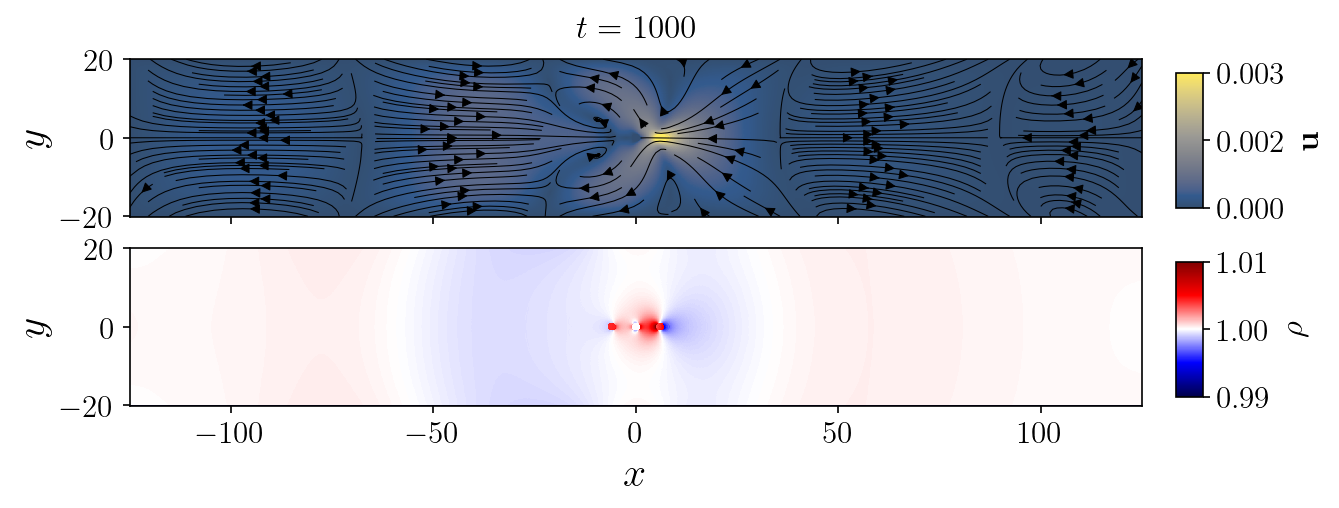

In [260]:
fig, axes = fluidOverview(fluidDf)
plt.show()

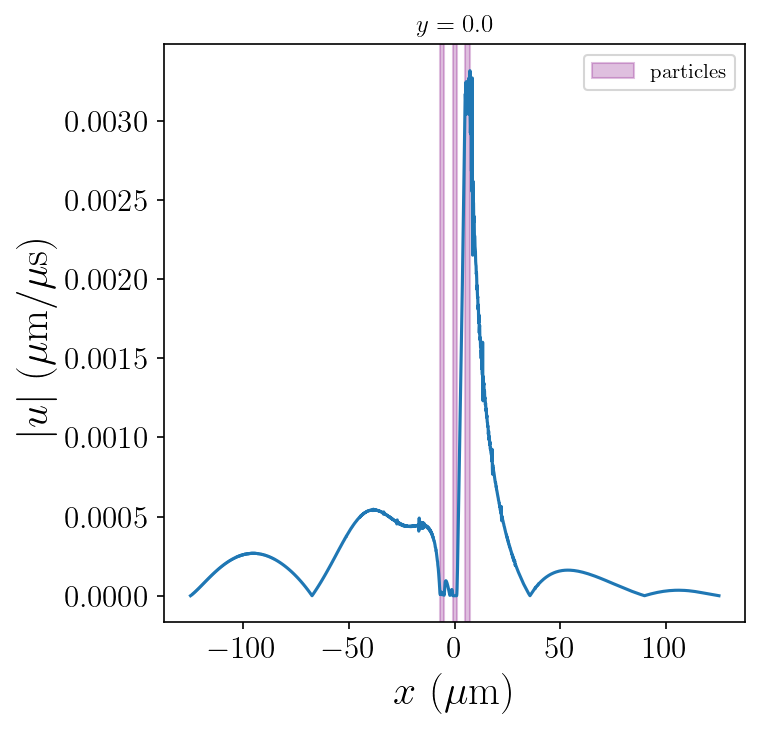

In [217]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.axvspan(-7, -5, color='purple', alpha=0.25, label = 'particles')
ax.axvspan(-1, 1, color='purple', alpha=0.25)
ax.axvspan(5, 7, color='purple', alpha=0.25)

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2)) 
ax.set_xlabel("$x~(\\mu \\mathrm{m})$")
ax.set_ylabel("$|u|~(\\mu \\mathrm{m}/\\mu \\mathrm{s})$")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
ax.legend()

plt.show()

In [218]:
def avgVelocity_X(df):
    return df.fluidVelocity_x.mean()

avgFluidVelocity_X = [
    avgVelocity_X(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

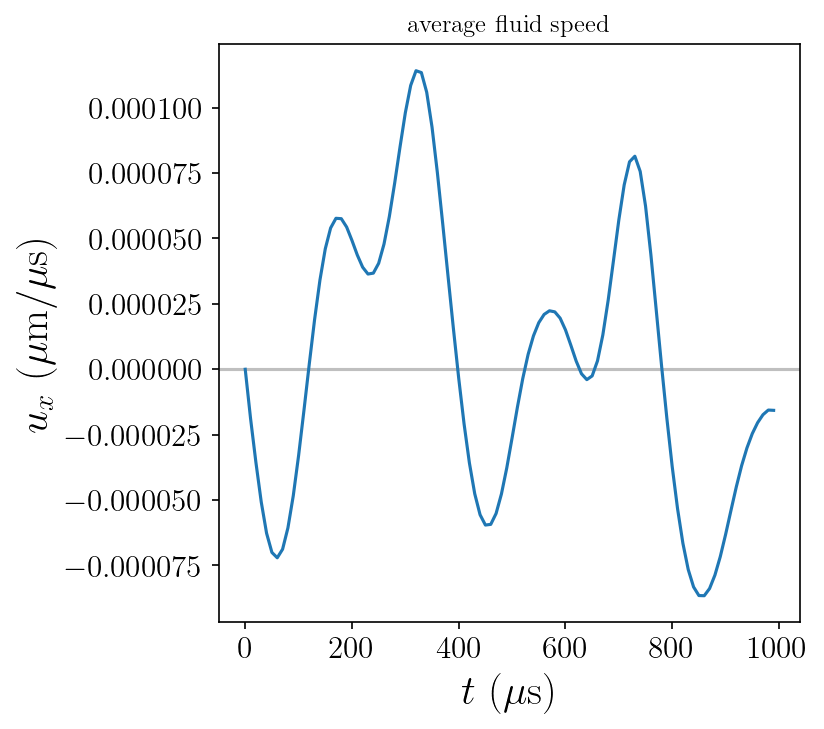

In [224]:
fig, ax = plt.subplots(figsize = (5,5))

firstFrame = 0
lastFrame = -1
ax.axhline(0, color = "gray", alpha = 0.5)
ax.plot(time[firstFrame:lastFrame], avgFluidVelocity_X[firstFrame:lastFrame])
ax.set_title("average fluid speed")
ax.set_xlabel("$t~(\\mu \\mathrm{s})$")
ax.set_ylabel("$u_x~(\\mu \\mathrm{m}/\\mu \\mathrm{s})$")

plt.show()

In [ ]:
initialTick = 36
avgFluidVelocity = pd.read_csv(dir + f"fluidTrj_{ticks[firstTick]}.csv").filter(['id_x', 'id_y','coordinate_x','coordinate_y', 'fluidVelocity_x', 'fluidVelocity_y']).set_index(["id_x","id_y"]).sort_index()

for tick in ticks[firstTick::]:
# for tick in ticks[18+1:42+1]:
    avgFluidVelocity['fluidVelocity_x'] += pd.read_csv(dir + f"fluidTrj_{tick}.csv").filter(['id_x', 'id_y', 'fluidVelocity_x']).set_index(["id_x","id_y"]).sort_index().fluidVelocity_x
    avgFluidVelocity['fluidVelocity_y'] += pd.read_csv(dir + f"fluidTrj_{tick}.csv").filter(['id_x', 'id_y', 'fluidVelocity_y']).set_index(["id_x","id_y"]).sort_index().fluidVelocity_y

avgFluidVelocity['fluidVelocity_x'] /= len(ticks[firstTick:lastTick])
avgFluidVelocity['fluidVelocity_y'] /= len(ticks[firstTick:lastTick])

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))


# Create a meshgrid for plotting
x_unique = avgFluidVelocity['coordinate_x'].unique()
y_unique = avgFluidVelocity['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

ax.streamplot(X, Y, 
    avgFluidVelocity.fluidVelocity_x.unstack().values.transpose(),
    avgFluidVelocity.fluidVelocity_y.unstack().values.transpose(),
    density=1.5, linewidth=0.5, color="black",
)

c = ax.pcolormesh(X, Y,
    np.sqrt(avgFluidVelocity.fluidVelocity_x**2 + avgFluidVelocity.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
ax.set_title('$\\langle\\mathbf{u}\\rangle (x,y)$; three particles')

ax.set_aspect('equal')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
cbar = fig.colorbar(c, ax=ax, shrink=.8)
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

# Fluid around the swimmer

In [241]:
boxRegion = f'-15 <= coordinate_x & coordinate_x <= 15 & -5 <= coordinate_y & coordinate_y <= 5'

In [242]:
initialTick = 20

In [243]:
avgFluidVelocity_X = [
    pd.read_csv(dir + f"fluidTrj_{tick}.csv").query(boxRegion).fluidVelocity_x.mean()
for tick in ticks[initialTick:]]

time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks[initialTick:]]

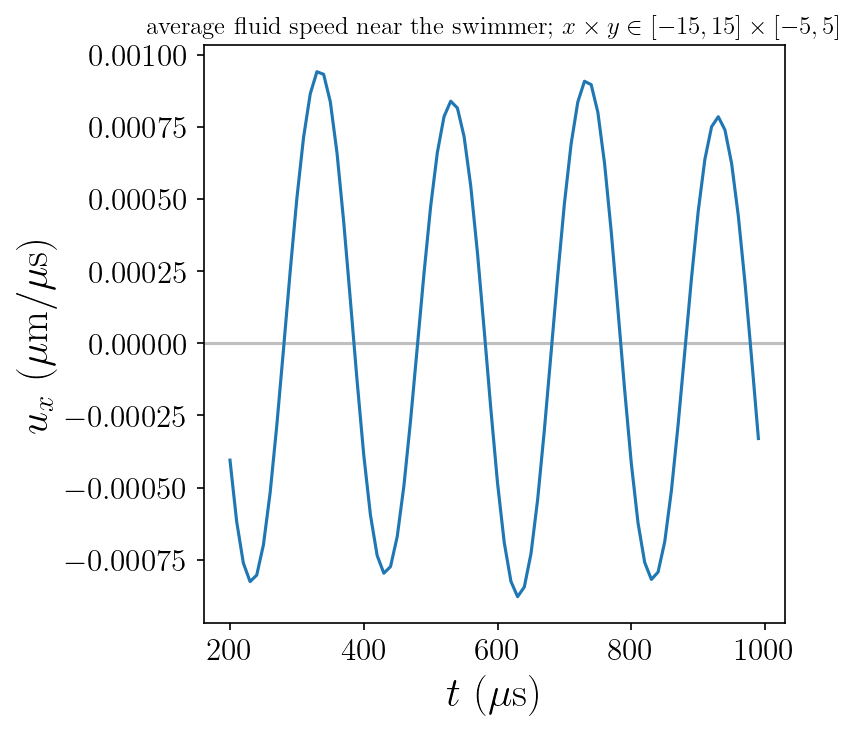

In [283]:
fig, ax = plt.subplots(figsize = (5,5))

firstFrame = 0
lastFrame = -1
ax.axhline(0, color = "gray", alpha = 0.5)
ax.plot(time[firstFrame:lastFrame], avgFluidVelocity_X[firstFrame:lastFrame])
# ax.plot(time[firstFrame:lastFrame], np.abs(avgFluidVelocity_X[firstFrame:lastFrame]))
ax.set_title("average fluid speed near the swimmer; $x \\times y \\in [-15, 15]\\times[-5, 5]$")
ax.set_xlabel("$t~(\\mu \\mathrm{s})$")
ax.set_ylabel("$u_x~(\\mu \\mathrm{m}/\\mu \\mathrm{s})$")

plt.show()

In [252]:
np.sum(0.5*(avgFluidVelocity_X + np.abs(avgFluidVelocity_X)))

np.float64(0.02254016719908821)

In [256]:
np.sum(0.5*(avgFluidVelocity_X - np.abs(avgFluidVelocity_X)))

np.float64(-0.021404660114280008)

In [261]:
avgFluidVelocity = pd.read_csv(dir + f"fluidTrj_{ticks[initialTick]}.csv").filter(['id_x', 'id_y','coordinate_x','coordinate_y', 'fluidVelocity_x', 'fluidVelocity_y']).set_index(["id_x","id_y"]).sort_index()

for tick in ticks[initialTick+1::]:
    avgFluidVelocity['fluidVelocity_x'] += pd.read_csv(dir + f"fluidTrj_{tick}.csv").filter(['id_x', 'id_y', 'fluidVelocity_x']).set_index(["id_x","id_y"]).sort_index().fluidVelocity_x
    avgFluidVelocity['fluidVelocity_y'] += pd.read_csv(dir + f"fluidTrj_{tick}.csv").filter(['id_x', 'id_y', 'fluidVelocity_y']).set_index(["id_x","id_y"]).sort_index().fluidVelocity_y

avgFluidVelocity['fluidVelocity_x'] /= len(ticks[initialTick::])
avgFluidVelocity['fluidVelocity_y'] /= len(ticks[initialTick::])

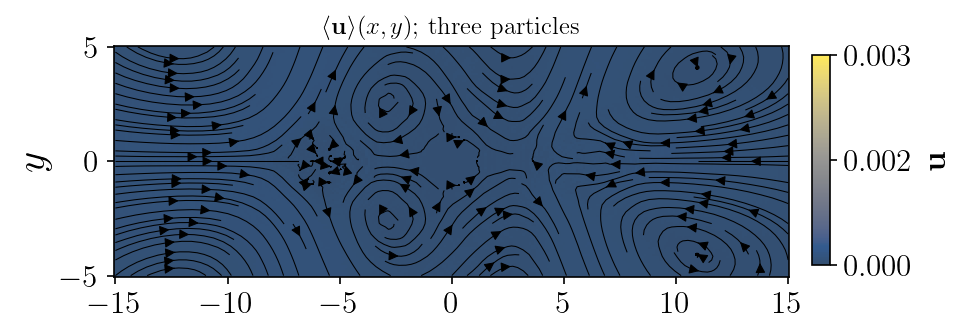

In [284]:
# figure preparation
fig, ax = plt.subplots(figsize = (6,2))

# fig.suptitle(f"$t = {avgFluidVelocity.time.values[0]:.0f}$", fontsize=16)
fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


# Create a meshgrid for plotting
x_unique = avgFluidVelocity.query(boxRegion)['coordinate_x'].unique()
y_unique = avgFluidVelocity.query(boxRegion)['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

# top plot
upperLim = 0.003
lowerLim = 0.
cmap = plt.get_cmap('cividis')
norm = plt.Normalize(lowerLim, upperLim)

ax.streamplot(X, Y, 
    avgFluidVelocity.query(boxRegion).fluidVelocity_x.unstack().values.transpose(),
    avgFluidVelocity.query(boxRegion).fluidVelocity_y.unstack().values.transpose(),
    density=1.5, linewidth=0.5, color="black",
)
ax.pcolormesh(X, Y,
    np.sqrt(avgFluidVelocity.query(boxRegion).fluidVelocity_x**2 + avgFluidVelocity.query(boxRegion).fluidVelocity_y**2).unstack().values.transpose(),
    vmin=lowerLim,
    vmax=upperLim,
    cmap=cmap, alpha = 0.8
);
# ax.tick_params(labelbottom=False)
ax.set_ylabel("$y$")

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height] for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.8)
cbar.set_label(label='$\\mathbf{u}$', fontsize=16)
cbar.ax.tick_params(labelsize=15)

custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([f'{tick:.3f}' for tick in custom_ticks])

ax.set_title('$\\langle\\mathbf{u}\\rangle (x,y)$; three particles')

plt.show()

# Stress tensor

In [ ]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

In [ ]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()